In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import scipy.stats
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(4, 4)})

from tqdm.notebook import tqdm
tqdm().pandas()


# Load in the acousticbrainz dataset into the variable 'acousticbrainz'
acousticbrainz = pd.read_hdf(Path.cwd() / 'datasets' / 'acousticbrainzV2.h5')

# Pooled variance metric
def get_variance(df):
    variances = df.groupby(level=0).var()
    samplesizes = df.groupby(level=0).size()
    
    a = variances.loc[variances.index.repeat(samplesizes)].reset_index(drop=True)
    return a

# Pooled variance metric with filtering
def get_variance_filt(df):
    filt = df.groupby(level=0).size() > 1
    filtered = df[filt[df.index.get_level_values(level=0)].values]
    return get_variance(filtered)

C:\Users\Chris\Miniconda3\envs\thesis2\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Since it appeared (notebook 'Effect of audio quality on stability.ipynb') that the audio quality can have a large influence on the stability of the classifier, it is also interesting to see if the codec has an effect on the stability. First we will look at the stability accross codecs. To make sure that the codec is the only factor we are studying, we compare the codecs for the same bit rates.

These comparisons are not really fair, codecs with way more submissions have a larger probability of having more variance, thus we can take the same approach as above, but downsample so that the amount of samples per codec is the same

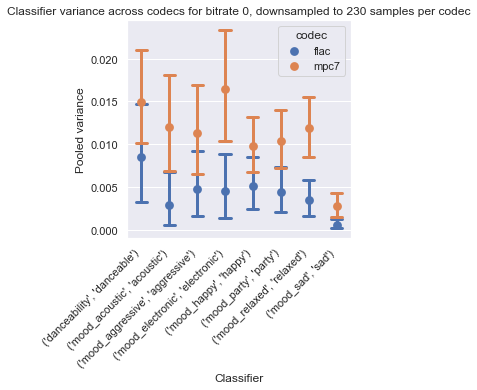

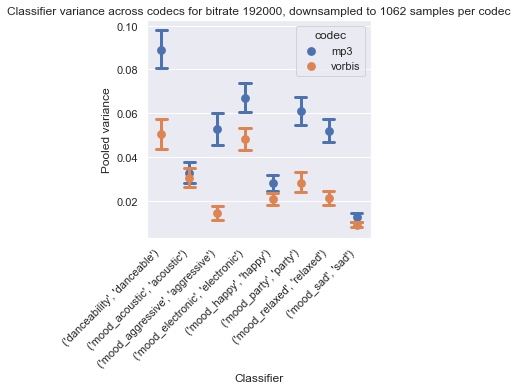

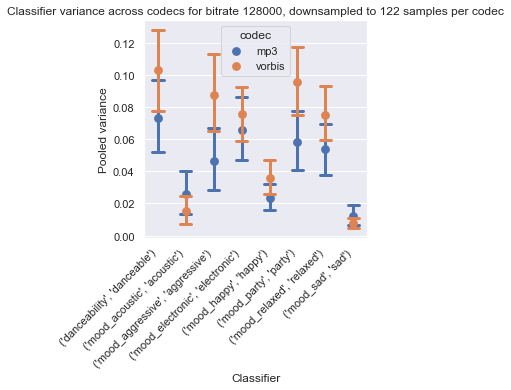

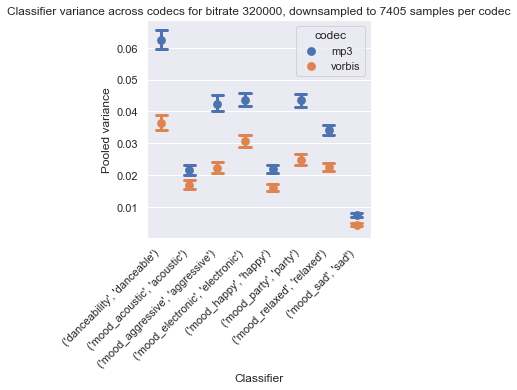

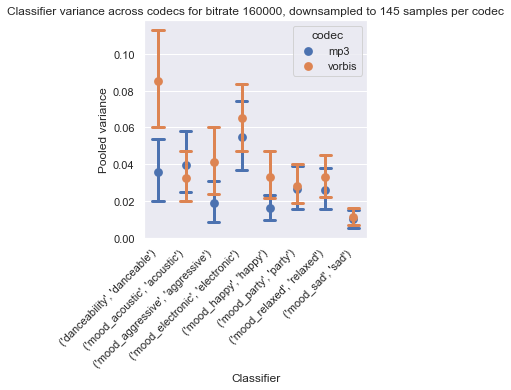

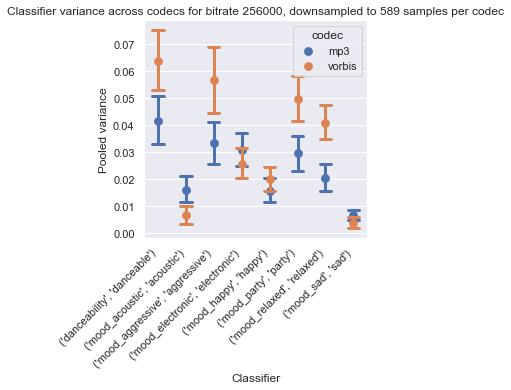

,flac,mpc7,mp3,vorbis
0,255317.0,230.0,NaN,NaN
192000,NaN,NaN,44768.0,1062.0
128000,NaN,NaN,34944.0,122.0
320000,NaN,NaN,25093.0,7405.0
160000,NaN,NaN,8074.0,145.0
256000,NaN,NaN,3560.0,589.0


In [2]:
# Get list of common bitrates
bitrates = list(acousticbrainz['bit_rate'].value_counts()[acousticbrainz['bit_rate'].value_counts() > 10000].index)

cols = [('danceability', 'danceable'), ('mood_acoustic', 'acoustic'), ('mood_aggressive', 'aggressive'),
('mood_electronic', 'electronic'), ('mood_happy', 'happy'), ('mood_party', 'party'),
('mood_relaxed', 'relaxed'), ('mood_sad', 'sad')]


distribution = pd.DataFrame()

for rate in bitrates:
    # Filter by bitrate 
    filtered = acousticbrainz[acousticbrainz['bit_rate'] == rate]
    
    # Remove codecs with n < 200
    filtered = filtered.groupby('codec').filter(lambda x: len(x) >= 200)
    
    # Remove recordings with only one submission
    filt = filtered.groupby(level=0).size() > 1
    filtered = filtered[filt[filtered.index.get_level_values(level=0)].values]

    distribution = distribution.append(filtered['codec'].value_counts())
    
    # Get lowest n for codec so that we can downsample to make n equal across codecs
    n = filtered['codec'].value_counts().min()
    
    # Calculate variances
    variances = filtered[cols].apply(get_variance)
    
    # Add codec column
    variances['codec'] = filtered['codec'].values

    # Downsample
    sampled = variances.groupby('codec').apply(lambda x: x.sample(n))
    
    
    ### PLOTTING ###
    
    toplot = sampled.reset_index(drop=True)
    toplot = toplot.unstack().unstack().transpose()
    toplot = pd.melt(toplot, id_vars=['codec'])
    
    plt.figure()
    ax = sns.pointplot(x='variable', y='value', hue='codec', data=toplot, ci=95, errwidth=3, capsize=.4,
                       dodge=False,
                       join=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.title(f"Classifier variance across codecs for bitrate {rate}, downsampled to {n} samples per codec")
    plt.xlabel('Classifier')
    plt.ylabel('Pooled variance')
    plt.show()

distribution.index = bitrates
display(distribution)

In [3]:
d2 = distribution
cols = [('Codec', 'flac'), ('Codec', 'mpc7'), ('Codec', 'mp3'), ('Codec', 'vorbis')]
d2.columns=pd.MultiIndex.from_tuples(cols)
d2.index.name = 'Bitrate'
d2 = d2.fillna(value=0).sort_index().astype(int)
display(d2)

print(d2.to_latex())

Codec                   
           flac mpc7    mp3 vorbis
Bitrate                           
0        255317  230      0      0
128000        0    0  34944    122
160000        0    0   8074    145
192000        0    0  44768   1062
256000        0    0   3560    589
320000        0    0  25093   7405

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{4}{l}{Codec} \\
{} &    flac & mpc7 &    mp3 & vorbis \\
Bitrate &         &      &        &        \\
\midrule
0       &  255317 &  230 &      0 &      0 \\
128000  &       0 &    0 &  34944 &    122 \\
160000  &       0 &    0 &   8074 &    145 \\
192000  &       0 &    0 &  44768 &   1062 \\
256000  &       0 &    0 &   3560 &    589 \\
320000  &       0 &    0 &  25093 &   7405 \\
\bottomrule
\end{tabular}



And how do bitrate and codec affect the correlation with the spotify data?

In [4]:
from scipy import stats

# Load in mapping and spotify data
mapping = pd.read_hdf(Path.cwd() / 'datasets' / 'mapping.h5')
spotify = pd.read_hdf(Path.cwd() / 'datasets' / 'spotify.h5')

# https://zhiyzuo.github.io/Pearson-Correlation-CI-in-Python/
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

# Define correlations to study
cols = [
    ('acousticness', ('mood_acoustic', 'acoustic')),
    ('danceability', ('danceability', 'danceable')),
    ('energy', ('mood_relaxed', 'not_relaxed')),
    ('instrumentalness', ('voice_instrumental', 'instrumental')),
    ('valence', ('mood_happy', 'happy')),
    ('valence', ('mood_sad', 'not_sad'))
]

# Get the correlations
def get_correlations(data, columns):
    corrs = {
        'classifier': [],
        'correlation': [],
        'p': [],
        'low': [],
        'high': []
    }
    for t in columns:
        corrs['classifier'].append(f"{t[0]} : {t[1]}")
        pearson_r = pearsonr_ci(data[t[0]], data[t[1]])
        corrs['correlation'].append(pearson_r[0])
        corrs['p'].append(pearson_r[1])
        corrs['low'].append(pearson_r[2])
        corrs['high'].append(pearson_r[3])
    return pd.DataFrame(corrs)

# Explicitly add mbid column to make merge possible
acousticbrainz['mbid'] = acousticbrainz.index.get_level_values(0)
merged = acousticbrainz.merge(mapping, on='mbid').merge(spotify, left_on='spotify', right_on='id')



correlation  \
bitrate classifier                                                        
448000  valence : ('mood_sad', 'not_sad')                      0.253805   
        valence : ('mood_happy', 'happy')                      0.319434   
        instrumentalness : ('voice_instrumental', 'inst...     0.442819   
        energy : ('mood_relaxed', 'not_relaxed')               0.591382   
        danceability : ('danceability', 'danceable')           0.337268   
        acousticness : ('mood_acoustic', 'acoustic')           0.743709   
320000  valence : ('mood_sad', 'not_sad')                      0.050631   
        valence : ('mood_happy', 'happy')                      0.197193   
        instrumentalness : ('voice_instrumental', 'inst...     0.255347   
        energy : ('mood_relaxed', 'not_relaxed')               0.377764   
        danceability : ('danceability', 'danceable')           0.296869   
        acousticness : ('mood_acoustic', 'acoustic')           0.670179   
256000  valence : ('mood_sad', 'not_sad')                     -0.094058   
        valence : ('mood_happy', 'happy')                      0.261975   
        instrumentalness : ('voice_instrumental', 'inst...     0.068804   
        energy : ('mood_relaxed', 'not_relaxed')               0.504075   
        danceability : ('danceability', 'danceable')           0.040660   
        acousticness : ('mood_acoustic', 'acoustic')           0.634159   
192000  valence : ('mood_sad', 'not_sad')                      0.128882   
        valence : ('mood_happy', 'happy')                      0.198142   
        instrumentalness : ('voice_instrumental', 'inst...     0.256714   
        energy : ('mood_relaxed', 'not_relaxed')               0.368992   
        danceability : ('danceability', 'danceable')           0.260703   
        acousticness : ('mood_acoustic', 'acoustic')           0.589482   
160000  valence : ('mood_sad', 'not_sad')                      0.110540   
        valence : ('mood_happy', 'happy')                      0.231516   
        instrumentalness : ('voice_instrumental', 'inst...     0.272531   
        energy : ('mood_relaxed', 'not_relaxed')               0.444428   
        danceability : ('danceability', 'danceable')           0.262184   
        acousticness : ('mood_acoustic', 'acoustic')           0.573389   
128000  valence : ('mood_sad', 'not_sad')                      0.124316   
        valence : ('mood_happy', 'happy')                      0.230036   
        instrumentalness : ('voice_instrumental', 'inst...     0.250611   
        energy : ('mood_relaxed', 'not_relaxed')               0.363422   
        danceability : ('danceability', 'danceable')           0.214128   
        acousticness : ('mood_acoustic', 'acoustic')           0.546922   

                                                                        p  \
bitrate classifier                                                          
448000  valence : ('mood_sad', 'not_sad')                    0.000000e+00   
        valence : ('mood_happy', 'happy')                    0.000000e+00   
        instrumentalness : ('voice_instrumental', 'inst...   0.000000e+00   
        energy : ('mood_relaxed', 'not_relaxed')             0.000000e+00   
        danceability : ('danceability', 'danceable')         0.000000e+00   
        acousticness : ('mood_acoustic', 'acoustic')         0.000000e+00   
320000  valence : ('mood_sad', 'not_sad')                    2.299317e-15   
        valence : ('mood_happy', 'happy')                   5.364755e-213   
        instrumentalness : ('voice_instrumental', 'inst...   0.000000e+00   
        energy : ('mood_relaxed', 'not_relaxed')             0.000000e+00   
        danceability : ('danceability', 'danceable')         0.000000e+00   
        acousticness : ('mood_acoustic', 'acoustic')         0.000000e+00   
256000  valence : ('mood_sad', 'not_sad')                    2.343897e-12   
        valence : ('mood_happy', 'happy')             

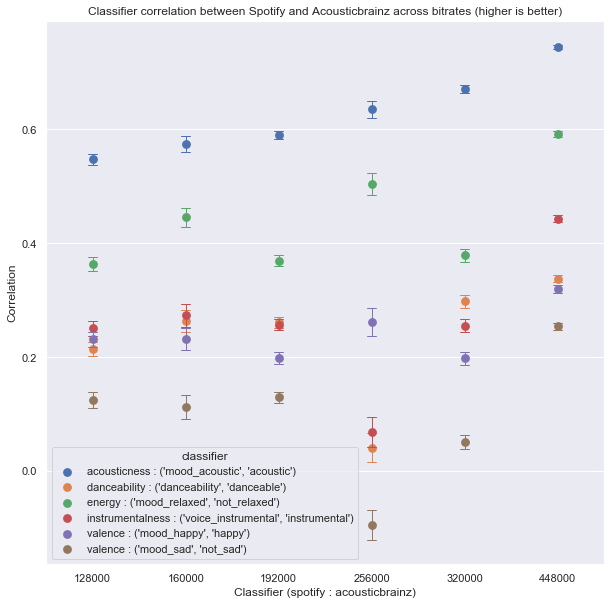

In [7]:
# Effect of bitrate
toplot = pd.DataFrame()
bitrateCounts = []
for rate in bitrates:
    filtered = merged[merged['bit_rate'] == rate]
    bitrateCounts.append(len(filtered))
    corrs = get_correlations(filtered, cols)
    
    if rate == 0:
        rate = 448000
    corrs['bitrate'] = rate
    toplot = toplot.append(corrs, ignore_index=True)
    
display(toplot.set_index(keys=['bitrate', 'classifier']).sort_index(ascending=False))

toplot['yerr'] = toplot['high'] - toplot['correlation']

#duplicate observations to get good std bars
dfCopy = toplot.copy()
duplicates = 1000 # increase this number to increase precision
for index, row in toplot.iterrows():
    for times in range(duplicates):
        new_row = row.copy()
        new_row['correlation'] = np.random.normal(row['correlation'],row['yerr']) 
        dfCopy = dfCopy.append(new_row, ignore_index=True)

# Now Seaborn does the rest
plt.figure(figsize=(10,10))
ax = sns.pointplot(x='bitrate',
                  y='correlation',
                  hue='classifier',
                  ci='sd',
                  data=dfCopy,
                  errwidth=1, 
                  capsize=.1,
                  join=False,
                  dodge=False)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title(f"Classifier correlation between Spotify and Acousticbrainz across bitrates (higher is better)")
plt.xlabel('Classifier (spotify : acousticbrainz)')
plt.ylabel('Correlation')
plt.show()

In [6]:
bitratedist = pd.DataFrame(bitrateCounts)
bitratedist.index = bitrates
print(bitratedist.to_latex())

\begin{tabular}{lr}
\toprule
{} &      0 \\
\midrule
0      &  71696 \\
192000 &  35177 \\
128000 &  20700 \\
320000 &  24465 \\
160000 &   8463 \\
256000 &   5536 \\
\bottomrule
\end{tabular}



And how does the codec for the same bitrate affect the correlation between acousticbrainz and spotify data?

Bitrate 192000:


correlation  \
codec  classifier                                                        
mp3    acousticness : ('mood_acoustic', 'acoustic')           0.554740   
       danceability : ('danceability', 'danceable')           0.280729   
       energy : ('mood_relaxed', 'not_relaxed')               0.352928   
       instrumentalness : ('voice_instrumental', 'inst...     0.242321   
       valence : ('mood_happy', 'happy')                      0.184123   
       valence : ('mood_sad', 'not_sad')                      0.132251   
vorbis acousticness : ('mood_acoustic', 'acoustic')           0.518555   
       danceability : ('danceability', 'danceable')          -0.062177   
       energy : ('mood_relaxed', 'not_relaxed')               0.446066   
       instrumentalness : ('voice_instrumental', 'inst...    -0.065867   
       valence : ('mood_happy', 'happy')                     -0.006749   
       valence : ('mood_sad', 'not_sad')                      0.297878   

                                                                      p  \
codec  classifier                                                         
mp3    acousticness : ('mood_acoustic', 'acoustic')        6.120691e-44   
       danceability : ('danceability', 'danceable')        5.102712e-11   
       energy : ('mood_relaxed', 'not_relaxed')            6.219754e-17   
       instrumentalness : ('voice_instrumental', 'inst...  1.708759e-08   
       valence : ('mood_happy', 'happy')                   2.069637e-05   
       valence : ('mood_sad', 'not_sad')                   2.326170e-03   
vorbis acousticness : ('mood_acoustic', 'acoustic')        1.122539e-37   
       danceability : ('danceability', 'danceable')        1.536631e-01   
       energy : ('mood_relaxed', 'not_relaxed')            3.528135e-27   
       instrumentalness : ('voice_instrumental', 'inst...  1.306428e-01   
       valence : ('mood_happy', 'happy')                   8.770553e-01   
       valence : ('mood_sad', 'not_sad')                   2.793583e-12   

                                                                low      high  
codec  classifier                                                              
mp3    acousticness : ('mood_acoustic', 'acoustic')        0.492732  0.611142  
       danceability : ('danceability', 'danceable')        0.200193  0.357497  
       energy : ('mood_relaxed', 'not_relaxed')            0.275905  0.425447  
       instrumentalness : ('voice_instrumental', 'inst...  0.160303  0.321015  
       valence : ('mood_happy', 'happy')                   0.100368  0.265287  
       valence : ('mood_sad', 'not_sad')                   0.047455  0.215155  
vorbis acousticness : ('mood_acoustic', 'acoustic')        0.453281  0.578298  
       danceability : ('danceability', 'danceable')       -0.146730  0.023278  
       energy : ('mood_relaxed', 'not_relaxed')            0.375008  0.511912  
       instrumentalness : ('voice_instrumental', 'inst... -0.150354  0.019574  
       valence : ('mood_happy', 'happy')                  -0.092027  0.078629  
       valence : ('mood_sad', 'not_sad')                   0.218089  0.373710

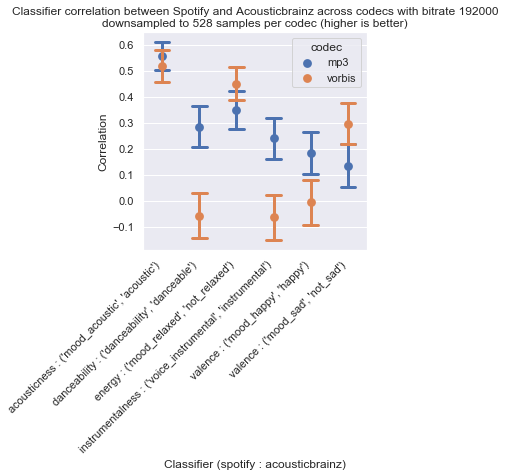

Bitrate 320000:


correlation  \
codec  classifier                                                        
mp3    acousticness : ('mood_acoustic', 'acoustic')           0.568016   
       danceability : ('danceability', 'danceable')           0.273956   
       energy : ('mood_relaxed', 'not_relaxed')               0.340336   
       instrumentalness : ('voice_instrumental', 'inst...     0.155530   
       valence : ('mood_happy', 'happy')                      0.120654   
       valence : ('mood_sad', 'not_sad')                      0.115228   
vorbis acousticness : ('mood_acoustic', 'acoustic')           0.762347   
       danceability : ('danceability', 'danceable')           0.280589   
       energy : ('mood_relaxed', 'not_relaxed')               0.538770   
       instrumentalness : ('voice_instrumental', 'inst...     0.450092   
       valence : ('mood_happy', 'happy')                      0.292821   
       valence : ('mood_sad', 'not_sad')                      0.116583   

                                                                       p  \
codec  classifier                                                          
mp3    acousticness : ('mood_acoustic', 'acoustic')         0.000000e+00   
       danceability : ('danceability', 'danceable')        1.712760e-125   
       energy : ('mood_relaxed', 'not_relaxed')            7.669638e-197   
       instrumentalness : ('voice_instrumental', 'inst...   1.195993e-40   
       valence : ('mood_happy', 'happy')                    5.128279e-25   
       valence : ('mood_sad', 'not_sad')                    6.034540e-23   
vorbis acousticness : ('mood_acoustic', 'acoustic')         0.000000e+00   
       danceability : ('danceability', 'danceable')        8.423121e-132   
       energy : ('mood_relaxed', 'not_relaxed')             0.000000e+00   
       instrumentalness : ('voice_instrumental', 'inst...   0.000000e+00   
       valence : ('mood_happy', 'happy')                   6.744854e-144   
       valence : ('mood_sad', 'not_sad')                    1.872567e-23   

                                                                low      high  
codec  classifier                                                              
mp3    acousticness : ('mood_acoustic', 'acoustic')        0.552250  0.583376  
       danceability : ('danceability', 'danceable')        0.252574  0.295071  
       energy : ('mood_relaxed', 'not_relaxed')            0.319865  0.360489  
       instrumentalness : ('voice_instrumental', 'inst...  0.133033  0.177866  
       valence : ('mood_happy', 'happy')                   0.097953  0.143229  
       valence : ('mood_sad', 'not_sad')                   0.092501  0.137835  
vorbis acousticness : ('mood_acoustic', 'acoustic')        0.752555  0.771803  
       danceability : ('danceability', 'danceable')        0.259289  0.301617  
       energy : ('mood_relaxed', 'not_relaxed')            0.522262  0.554874  
       instrumentalness : ('voice_instrumental', 'inst...  0.431582  0.468223  
       valence : ('mood_happy', 'happy')                   0.271677  0.313683  
       valence : ('mood_sad', 'not_sad')                   0.093863  0.139183

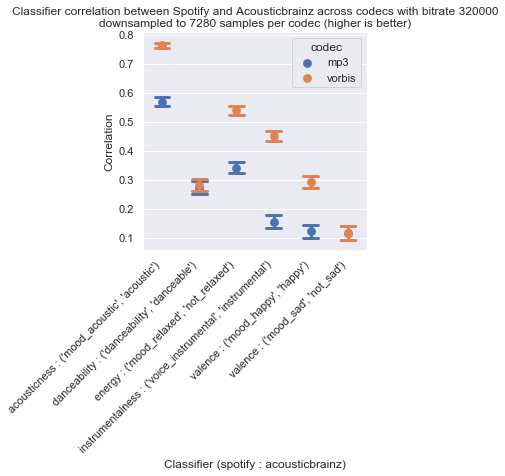

Bitrate 160000:


correlation  \
codec  classifier                                                        
mp3    acousticness : ('mood_acoustic', 'acoustic')           0.567791   
       danceability : ('danceability', 'danceable')           0.317069   
       energy : ('mood_relaxed', 'not_relaxed')               0.365688   
       instrumentalness : ('voice_instrumental', 'inst...     0.355480   
       valence : ('mood_happy', 'happy')                      0.261762   
       valence : ('mood_sad', 'not_sad')                      0.164241   
vorbis acousticness : ('mood_acoustic', 'acoustic')           0.427185   
       danceability : ('danceability', 'danceable')           0.223683   
       energy : ('mood_relaxed', 'not_relaxed')               0.507675   
       instrumentalness : ('voice_instrumental', 'inst...     0.013231   
       valence : ('mood_happy', 'happy')                      0.154805   
       valence : ('mood_sad', 'not_sad')                      0.005898   

                                                                      p  \
codec  classifier                                                         
mp3    acousticness : ('mood_acoustic', 'acoustic')        4.319848e-48   
       danceability : ('danceability', 'danceable')        2.905159e-14   
       energy : ('mood_relaxed', 'not_relaxed')            8.804485e-19   
       instrumentalness : ('voice_instrumental', 'inst...  9.118976e-18   
       valence : ('mood_happy', 'happy')                   4.892712e-10   
       valence : ('mood_sad', 'not_sad')                   1.123386e-04   
vorbis acousticness : ('mood_acoustic', 'acoustic')        1.023514e-25   
       danceability : ('danceability', 'danceable')        1.213016e-07   
       energy : ('mood_relaxed', 'not_relaxed')            3.076144e-37   
       instrumentalness : ('voice_instrumental', 'inst...  7.572919e-01   
       valence : ('mood_happy', 'happy')                   2.752220e-04   
       valence : ('mood_sad', 'not_sad')                   8.904314e-01   

                                                                low      high  
codec  classifier                                                              
mp3    acousticness : ('mood_acoustic', 'acoustic')        0.508200  0.621970  
       danceability : ('danceability', 'danceable')        0.239675  0.390458  
       energy : ('mood_relaxed', 'not_relaxed')            0.290837  0.436090  
       instrumentalness : ('voice_instrumental', 'inst...  0.280060  0.426539  
       valence : ('mood_happy', 'happy')                   0.181993  0.338108  
       valence : ('mood_sad', 'not_sad')                   0.081605  0.244635  
vorbis acousticness : ('mood_acoustic', 'acoustic')        0.356170  0.493294  
       danceability : ('danceability', 'danceable')        0.142596  0.301788  
       energy : ('mood_relaxed', 'not_relaxed')            0.442743  0.567311  
       instrumentalness : ('voice_instrumental', 'inst... -0.070606  0.096883  
       valence : ('mood_happy', 'happy')                   0.071979  0.235510  
       valence : ('mood_sad', 'not_sad')                  -0.077899  0.089613

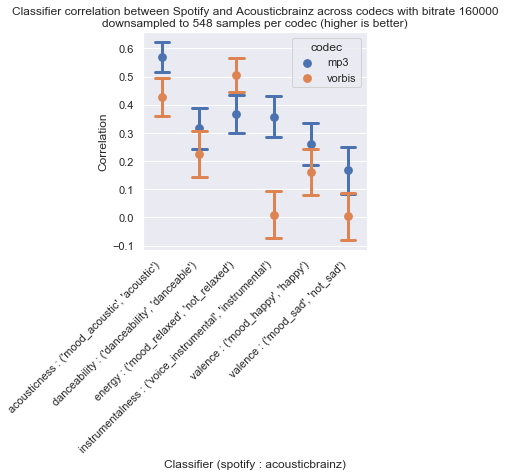

Bitrate 256000:


correlation  \
codec  classifier                                                        
mp3    acousticness : ('mood_acoustic', 'acoustic')           0.576822   
       danceability : ('danceability', 'danceable')           0.215246   
       energy : ('mood_relaxed', 'not_relaxed')               0.408947   
       instrumentalness : ('voice_instrumental', 'inst...     0.205911   
       valence : ('mood_happy', 'happy')                      0.215908   
       valence : ('mood_sad', 'not_sad')                      0.136845   
vorbis acousticness : ('mood_acoustic', 'acoustic')           0.691514   
       danceability : ('danceability', 'danceable')           0.156174   
       energy : ('mood_relaxed', 'not_relaxed')               0.487232   
       instrumentalness : ('voice_instrumental', 'inst...     0.172543   
       valence : ('mood_happy', 'happy')                      0.229062   
       valence : ('mood_sad', 'not_sad')                     -0.208755   

                                                                       p  \
codec  classifier                                                          
mp3    acousticness : ('mood_acoustic', 'acoustic')        9.980369e-222   
       danceability : ('danceability', 'danceable')         1.362590e-27   
       energy : ('mood_relaxed', 'not_relaxed')            2.096896e-101   
       instrumentalness : ('voice_instrumental', 'inst...   2.425967e-25   
       valence : ('mood_happy', 'happy')                    9.347508e-28   
       valence : ('mood_sad', 'not_sad')                    6.367749e-12   
vorbis acousticness : ('mood_acoustic', 'acoustic')         0.000000e+00   
       danceability : ('danceability', 'danceable')         4.060987e-15   
       energy : ('mood_relaxed', 'not_relaxed')            3.213603e-149   
       instrumentalness : ('voice_instrumental', 'inst...   3.686580e-18   
       valence : ('mood_happy', 'happy')                    4.027890e-31   
       valence : ('mood_sad', 'not_sad')                    5.135533e-26   

                                                                low      high  
codec  classifier                                                              
mp3    acousticness : ('mood_acoustic', 'acoustic')        0.550058  0.602403  
       danceability : ('danceability', 'danceable')        0.177542  0.252320  
       energy : ('mood_relaxed', 'not_relaxed')            0.375768  0.441078  
       instrumentalness : ('voice_instrumental', 'inst...  0.168065  0.243151  
       valence : ('mood_happy', 'happy')                   0.178214  0.252970  
       valence : ('mood_sad', 'not_sad')                   0.098169  0.175108  
vorbis acousticness : ('mood_acoustic', 'acoustic')        0.670487  0.711430  
       danceability : ('danceability', 'danceable')        0.117692  0.194188  
       energy : ('mood_relaxed', 'not_relaxed')            0.456754  0.516568  
       instrumentalness : ('voice_instrumental', 'inst...  0.134248  0.210323  
       valence : ('mood_happy', 'happy')                   0.191579  0.265877  
       valence : ('mood_sad', 'not_sad')                  -0.245945 -0.170952

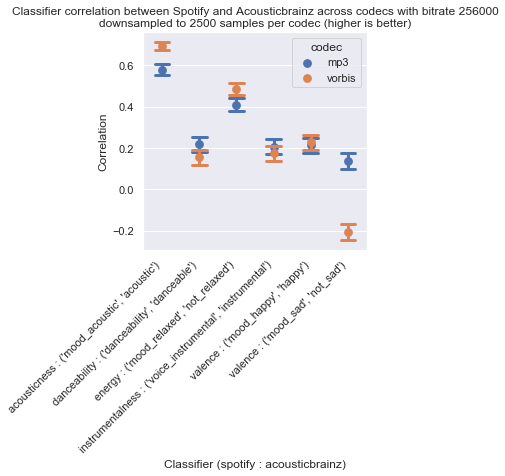

In [7]:
rate_index = []
codec_index = []
counts = []

for rate in bitrates:
    # Filter on bitrate
    filtered = merged[merged['bit_rate'] == rate]
    
    # Remove codecs with n < 200
    filtered = filtered.groupby('codec').filter(lambda x: len(x) >= 200) 
    
    # Count distribution for reporting
    valcounts = filtered['codec'].value_counts().to_frame()
    for (k, v) in valcounts.iterrows():
        rate_index.append(rate)
        codec_index.append(k)
        counts.append(v)
    
    # Get lowest n for codec so that we can downsample to make n equal across codecs
    n = filtered['codec'].value_counts().min()
    
    # Only if we have at least two codecs in the data can we make the comparison
    if len(filtered['codec'].value_counts()) > 1:
        print(f"Bitrate {rate}:")
        
        # Downsample so groups are equal
        filtered = filtered.groupby('codec').apply(lambda x: x.sample(n))
        
        # Calculate correlations per codec
        corrs = filtered.groupby(level=0).apply(lambda x: get_correlations(x, cols))
        display(corrs.droplevel(level=1).set_index(['classifier'], append=True))
        corrs = corrs.reset_index()
        
        corrs['yerr'] = corrs['high'] - corrs['correlation']

        #duplicate observations to get good std bars
        dfCopy = corrs.copy()
        duplicates = 1000 # increase this number to increase precision
        for index, row in corrs.iterrows():
            for times in range(duplicates):
                new_row = row.copy()
                new_row['correlation'] = np.random.normal(row['correlation'],row['yerr']) 
                dfCopy = dfCopy.append(new_row, ignore_index=True)

        # Now Seaborn does the rest
        plt.figure()
        ax = sns.pointplot(x='classifier',
                          y='correlation',
                          hue='codec',
                          ci='sd',
                          data=dfCopy,
                          errwidth=3, 
                         capsize=.4,
                         dodge=False,
                         join=False)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        plt.title(f"Classifier correlation between Spotify and Acousticbrainz across codecs with bitrate {rate}\ndownsampled to {n} samples per codec (higher is better)")
        plt.xlabel('Classifier (spotify : acousticbrainz)')
        plt.ylabel('Correlation')
        plt.show()
        

In [8]:
counts_unpack = np.array(counts).flatten()
codecdist = pd.DataFrame([rate_index,codec_index,counts_unpack]).transpose().iloc[[1,2,4,5,6,7,8,9]]
codecdist.columns=['Bitrate', 'Codec', 'Count']

print(codecdist.set_index(keys=['Bitrate', 'Codec']).sort_index(level=0).to_latex())

\begin{tabular}{lll}
\toprule
       &        &  Count \\
Bitrate & Codec &        \\
\midrule
160000 & mp3 &   7915 \\
       & vorbis &    548 \\
192000 & mp3 &  34634 \\
       & vorbis &    528 \\
256000 & mp3 &   3025 \\
       & vorbis &   2500 \\
320000 & mp3 &  17181 \\
       & vorbis &   7280 \\
\bottomrule
\end{tabular}



Lastly, how does the low level feature extraction version influence both the stability and the correlations?

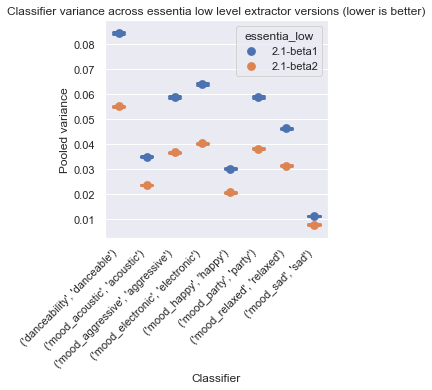

In [9]:
cols = [('danceability', 'danceable'), ('mood_acoustic', 'acoustic'), ('mood_aggressive', 'aggressive'),
('mood_electronic', 'electronic'), ('mood_happy', 'happy'), ('mood_party', 'party'),
('mood_relaxed', 'relaxed'), ('mood_sad', 'sad')]


# Remove recordings with only one submission
filt = acousticbrainz.groupby(level=0).size() > 1
filtered = acousticbrainz[filt[acousticbrainz.index.get_level_values(level=0)].values]

# Calculate variances
var = get_variance(filtered[cols])
var['essentia_low'] = filtered['essentia_low'].values

toplot = pd.melt(var, id_vars=['essentia_low'])

plt.figure()
ax = sns.pointplot(x='variable', y='value', hue='essentia_low', data=toplot, ci=95, errwidth=3, 
                         capsize=.4,
                         dodge=False,
                         join=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title(f"Classifier variance across essentia low level extractor versions (lower is better)")
plt.xlabel('Classifier')
plt.ylabel('Pooled variance')
plt.show()

correlation  \
essentia_low classifier                                                        
2.1-beta2    valence : ('mood_sad', 'not_sad')                      0.131179   
             valence : ('mood_happy', 'happy')                      0.301206   
             instrumentalness : ('voice_instrumental', 'inst...     0.420489   
             energy : ('mood_relaxed', 'not_relaxed')               0.566086   
             danceability : ('danceability', 'danceable')           0.320089   
             acousticness : ('mood_acoustic', 'acoustic')           0.727159   
2.1-beta1    valence : ('mood_sad', 'not_sad')                      0.239811   
             valence : ('mood_happy', 'happy')                      0.113506   
             instrumentalness : ('voice_instrumental', 'inst...     0.140629   
             energy : ('mood_relaxed', 'not_relaxed')               0.310273   
             danceability : ('danceability', 'danceable')           0.142510   
             acousticness : ('mood_acoustic', 'acoustic')           0.505147   

                                                                             p  \
essentia_low classifier                                                          
2.1-beta2    valence : ('mood_sad', 'not_sad')                    0.000000e+00   
             valence : ('mood_happy', 'happy')                    0.000000e+00   
             instrumentalness : ('voice_instrumental', 'inst...   0.000000e+00   
             energy : ('mood_relaxed', 'not_relaxed')             0.000000e+00   
             danceability : ('danceability', 'danceable')         0.000000e+00   
             acousticness : ('mood_acoustic', 'acoustic')         0.000000e+00   
2.1-beta1    valence : ('mood_sad', 'not_sad')                    0.000000e+00   
             valence : ('mood_happy', 'happy')                   2.980968e-268   
             instrumentalness : ('voice_instrumental', 'inst...   0.000000e+00   
             energy : ('mood_relaxed', 'not_relaxed')             0.000000e+00   
             danceability : ('danceability', 'danceable')         0.000000e+00   
             acousticness : ('mood_acoustic', 'acoustic')         0.000000e+00   

                                                                      low  \
essentia_low classifier                                                     
2.1-beta2    valence : ('mood_sad', 'not_sad')                   0.126436   
             valence : ('mood_happy', 'happy')                   0.296815   
             instrumentalness : ('voice_instrumental', 'inst...  0.416511   
             energy : ('mood_relaxed', 'not_relaxed')            0.562800   
             danceability : ('danceability', 'danceable')        0.315754   
             acousticness : ('mood_acoustic', 'acoustic')        0.724878   
2.1-beta1    valence : ('mood_sad', 'not_sad')                   0.233791   
             valence : ('mood_happy', 'happy')                   0.107205   
             instrumentalness : ('voice_instrumental', 'inst...  0.134371   
             energy : ('mood_relaxed', 'not_relaxed')            0.304498   
             danceability : ('danceability', 'danceable')        0.136255   
             acousticness : ('mood_acoustic', 'acoustic')        0.500381   

                                                                     high  
essentia_low classifier                                                    
2.1-beta2    valence : ('mood_sad', 'not_sad')                   0.135916  
             valence : ('mood_happy', 'happy')                   0.305585  
             instrumentalness : ('voice_instrumental', 'inst...  0.424451  
             energy : ('mood_relaxed', 'not_relaxed')            0.569355  
             danceability : ('danceability', 'danceable')        0.324411  
             acousticness : ('mood_acoustic', 'acoustic')        0.729424  
2.1-beta1    valence : ('mood_sad', 'not_sad')                   0.245813  
             valence : ('mood_ha

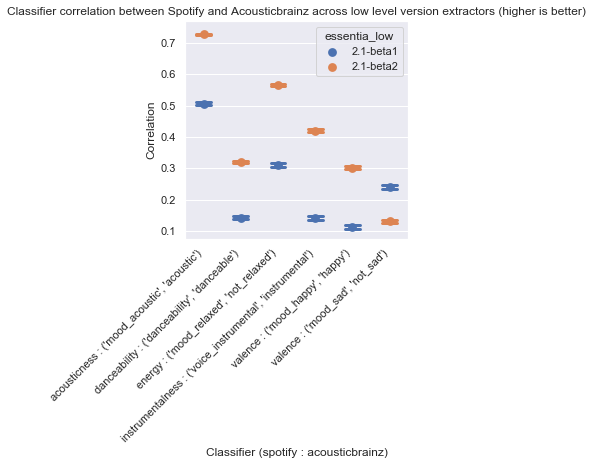

In [10]:
# Define correlations to study
cols = [
    ('acousticness', ('mood_acoustic', 'acoustic')),
    ('danceability', ('danceability', 'danceable')),
    ('energy', ('mood_relaxed', 'not_relaxed')),
    ('instrumentalness', ('voice_instrumental', 'instrumental')),
    ('valence', ('mood_happy', 'happy')),
    ('valence', ('mood_sad', 'not_sad'))
]

vers = ['2.1-beta1', '2.1-beta2']

# Effect of low level extractor
toplot = pd.DataFrame()
for ver in vers:
    filtered = merged[merged['essentia_low'] == ver]
    corrs = get_correlations(filtered, cols)
    corrs['essentia_low'] = ver
    toplot = toplot.append(corrs, ignore_index=True)
    
display(toplot.set_index(keys=['essentia_low', 'classifier']).sort_index(ascending=False))

toplot['yerr'] = toplot['high'] - toplot['correlation']

#duplicate observations to get good std bars
dfCopy = toplot.copy()
duplicates = 1000 # increase this number to increase precision
for index, row in toplot.iterrows():
    for times in range(duplicates):
        new_row = row.copy()
        new_row['correlation'] = np.random.normal(row['correlation'],row['yerr']) 
        dfCopy = dfCopy.append(new_row, ignore_index=True)

# Now Seaborn does the rest
plt.figure()
ax = sns.pointplot(x='classifier',
                  y='correlation',
                  hue='essentia_low',
                  ci='sd',
                  data=dfCopy,
                  errwidth=3, 
                  capsize=.4,
                  dodge=False,
                  join=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title(f"Classifier correlation between Spotify and Acousticbrainz across low level version extractors (higher is better)")
plt.xlabel('Classifier (spotify : acousticbrainz)')
plt.ylabel('Correlation')
plt.show()

# Best case scenario
So it appears that lossless performs better overall than lossy, and 2.1-beta2 for the low level features performs better both in stability and correlation of the high level features. Let's see if filtering on only that data gives respectable correlation with the spotify data

In [11]:
# Best case?
toCalc = merged[(merged['essentia_low'] == '2.1-beta2') & (merged['lossless'] == 1)]
get_correlations(toCalc, cols)

,classifier,correlation,p,low,high
0,"acousticness : ('mood_acoustic', 'acoustic')",0.738342,0.0,0.733867,0.742754
1,"danceability : ('danceability', 'danceable')",0.310374,0.0,0.301519,0.319176
2,"energy : ('mood_relaxed', 'not_relaxed')",0.572231,0.0,0.565624,0.578765
3,"instrumentalness : ('voice_instrumental', 'ins...",0.440534,0.0,0.432627,0.448374
4,"valence : ('mood_happy', 'happy')",0.299208,0.0,0.290287,0.308076
5,"valence : ('mood_sad', 'not_sad')",0.233807,0.0,0.224550,0.243021


In [12]:
metacols = ['essentia_high', 'extractor_high', 'gaia_high', 'essentia_low', 'extractor_low']
meta = acousticbrainz[metacols]

for col in metacols:
    display(meta[col].value_counts())


2.1-beta1    1805912
Name: essentia_high, dtype: int64

music 1.0    1805912
Name: extractor_high, dtype: int64

2.4-dev    1805912
Name: gaia_high, dtype: int64

2.1-beta2    1142046
2.1-beta1     663866
Name: essentia_low, dtype: int64

music 1.0    1805912
Name: extractor_low, dtype: int64